**Table of contents**<a id='toc0_'></a>    
- [Cleaned Analysis of June 23rd 2023 Flight at 100 Hz](#toc1_)    
  - [Purpose:](#toc1_1_)    
  - [Methods:](#toc1_2_)    
  - [Results](#toc1_3_)    
  - [Naming and Folders](#toc1_4_)    
  - [Importing Packages and Libraries](#toc1_5_)    
  - [Importing Data](#toc1_6_)    
  - [Defining Vehicle Parameters](#toc1_7_)    
  - [Manually Selecting Masks by Plots](#toc1_8_)    
  - [Results of Manual Segmentation](#toc1_9_)    
    - [Acceleration Segments](#toc1_9_1_)    
    - [IMU Calibration Segments](#toc1_9_2_)    
  - [Checking Segments for Good Data](#toc1_10_)    
    - [Plotting Airspeeds, Altitude and Motor RPM for Checks](#toc1_10_1_)    
    - [Showing the Rotational Rate of Vehicle](#toc1_10_2_)    
    - [Checking IMU Calibration Segment](#toc1_10_3_)    
  - [Post-Flight IMU Orientation Calibration](#toc1_11_)    
    - [Calculating Body Accelerations w. Adjustment for g Magnitude](#toc1_11_1_)    
    - [Calculating Body Accelerations w, Adjustment for IMU Orientation](#toc1_11_2_)    
  - [Main Analysis for P_Req](#toc1_12_)    
    - [Power Required With IMU Orientation Adjustment](#toc1_12_1_)    
      - [Notes for the investigation of Power Terms above](#toc1_12_1_1_)    
    - [Lift Measurement with IMU Orientation Adjustment](#toc1_12_2_)    
      - [Lift Estimate Notes](#toc1_12_2_1_)    
  - [Collecting Total Results for Polar](#toc1_13_)    
    - [IMU Adjusted Results](#toc1_13_1_)    
  - [Binning Total Results for Polar](#toc1_14_)    
  - [Plotting Results of Binning](#toc1_15_)    
  - [Performing Curve Fits to Find Polars](#toc1_16_)    
  - [Packaging the Results](#toc1_17_)    
  - [Saving Results to Disk](#toc1_18_)    
  - [Additional Plots](#toc1_19_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Cleaned Analysis of June 23rd 2023 Flight at 100 Hz](#toc0_)

## <a id='toc1_1_'></a>[Purpose:](#toc0_)
* Reduce the code to just the essentials
* Comment on the results

## <a id='toc1_2_'></a>[Methods:](#toc0_)
1. Acceleration method
   1. 

## <a id='toc1_3_'></a>[Results](#toc0_)
Confirmed to agree with the main scirpt that this was based off.  

## <a id='toc1_4_'></a>[Naming and Folders](#toc0_)

In [1]:
### Definining name of analysis ###
name = '2023-06-23_CREATeV_Acceleration_Analysis_Cleaned_IMU_Cal_MS4525'
data_path = '../../data/'
data_folder = 'createv-2023-06-23'
file_name = '00000012.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## <a id='toc1_5_'></a>[Importing Packages and Libraries](#toc0_)

In [2]:
# Getting packages #
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px

import main
import propellers
import motors
from aircraft import airplane
import cl_finders

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## <a id='toc1_6_'></a>[Importing Data](#toc0_)

In [3]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2023"
df = main.data_load(data_path, data_folder, file_name, rate, interpolateM, processor)

In [4]:
ct_cruise_segresult_june13 = pd.read_pickle("../Results/2022-06-15_CREATeV_Cruise_Analysis_Cleaned/ct_cruise_segresult.pkl")
build_turbulent = pd.read_pickle("../../DragBuilds/CREATeV_DragBuildTurbulent.pkl")
build_laminar = pd.read_pickle("../../DragBuilds/CREATeV_DragBuildLaminar.pkl")

## <a id='toc1_7_'></a>[Defining Vehicle Parameters](#toc0_)

In [5]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.502
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

## <a id='toc1_8_'></a>[Manually Selecting Masks by Plots](#toc0_)

Using the throttle ramp beginning and end, while looking for when the advance ratio of the propeller is suitable for no singularities.  

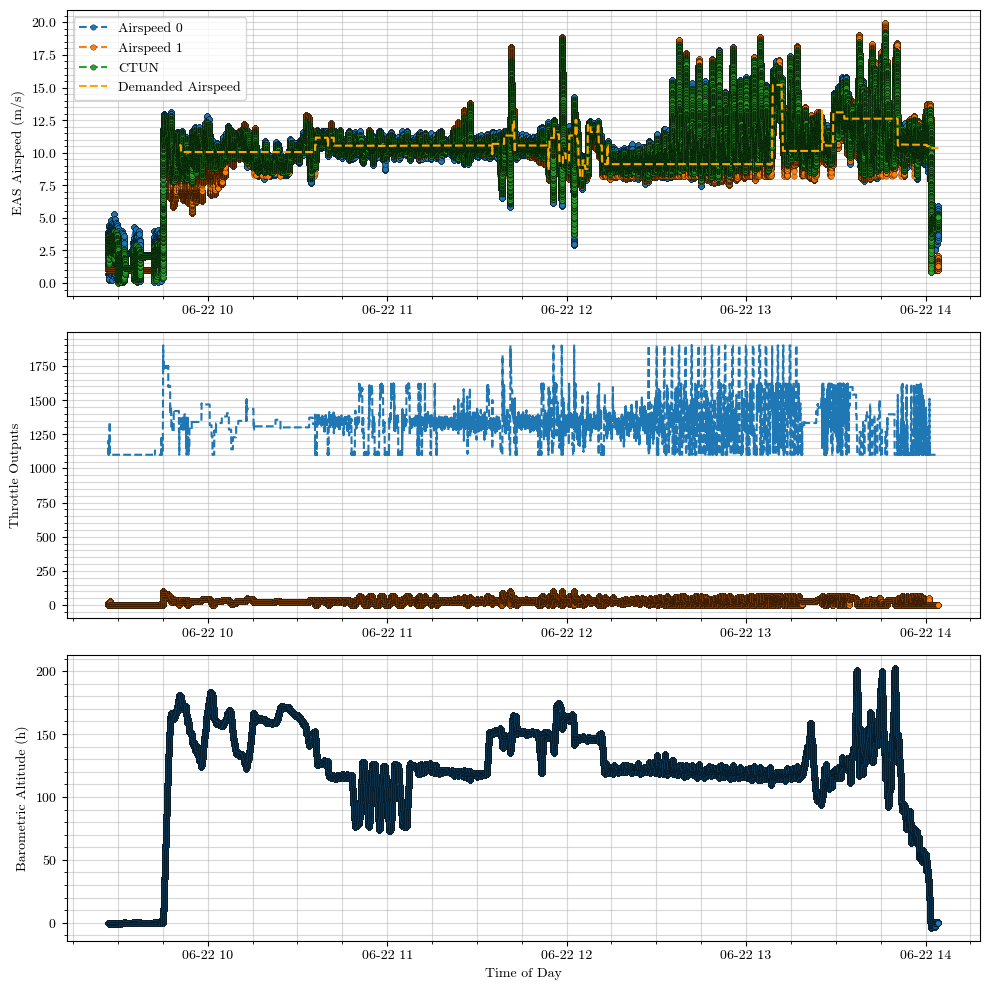

In [6]:
# Generating Plots for Mask Selection

timeindex_v_thr_h = plt.figure(figsize=(10,10), dpi=100)

df.Airspeed_Sensor1 = np.where(df.Airspeed_Sensor1 < 8.2, df.Airspeed_Sensor1 + 0.976, df.Airspeed_Sensor1)
#df.loc[df.Airspeed_Sensor0 < 8.2, 'Airspeed_Sensor0'] += (9.087 - 8.111)
ax0 = plt.subplot(3,1,1)
plt.grid("On")
plt.plot(df.index, df.Airspeed_Sensor0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0], label='Airspeed 0')
plt.plot(df.index, df.Airspeed_Sensor1, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0], label='Airspeed 1')
plt.plot(df.index, df.Airspeed_CTUN, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0], label='CTUN')
plt.plot(df.index, df.Airspeed_Demanded, color='orange', linestyle='--', marker='', label="Demanded Airspeed")
plt.legend(loc='upper left')
plt.ylabel("EAS Airspeed (m/s)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.ThrottleOut, linestyle='--', marker='', markersize=4, markeredgecolor=[0,0,0])
plt.plot(df.index, df.Throttle, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Throttle Outputs")
ax2 = plt.subplot(3,1,3, sharex=ax0)
plt.grid("On")
plt.plot(df.index, df.Altitude_BARO_0, linestyle='--', marker='o', markersize=4, markeredgecolor=[0,0,0])
plt.ylabel("Barometric Altitude (h)")
plt.xlabel("Time of Day")
plt.grid("On")
plt.show()
main.save_figure(timeindex_v_thr_h, f'{timeindex_v_thr_h=}'.split('=')[0], figure_path)

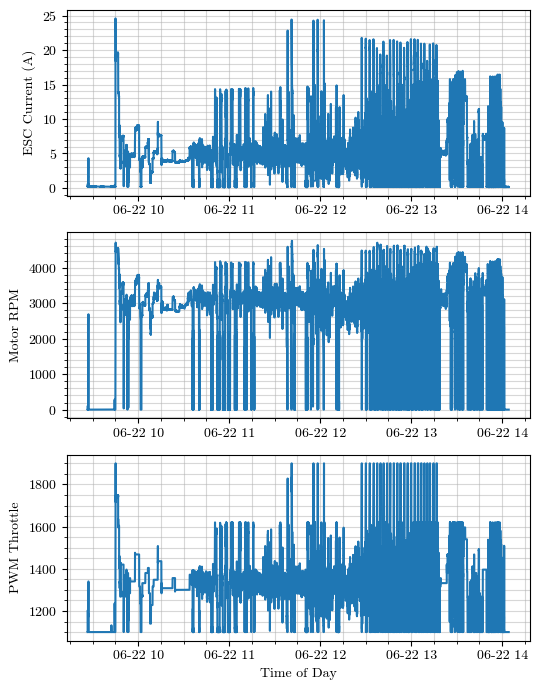

In [7]:
# Plotting Propulsion Information for Mask Selection
timeindex_I_RPM_thr = plt.figure(figsize=(5.5,7), dpi=100)

ax0 = plt.subplot(3,1,1)
ax0.plot(df.index, df.MainBatteryCurrent, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])
ax0.set_ylabel("ESC Current (A)")
ax1 = plt.subplot(3,1,2, sharex=ax0)
ax1.plot(df.index, df.MotorRPM, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])
ax1.set_ylabel("Motor RPM")
ax2 = plt.subplot(3,1,3, sharex=ax0)
ax2.plot(df.index, df.ThrottleOut, linestyle='-', marker='', markersize=4, markeredgecolor=[0,0,0])
ax2.set_ylabel("PWM Throttle")
ax2.set_xlabel("Time of Day")
plt.show()
main.save_figure(timeindex_I_RPM_thr, f'{timeindex_I_RPM_thr=}'.split('=')[0], figure_path)

## <a id='toc1_9_'></a>[Results of Manual Segmentation](#toc0_)

### <a id='toc1_9_1_'></a>[Acceleration Segments](#toc0_)

In [8]:
year = 2023
month = 6
day = 22

# Acceleration Masking from the above figures
seg_times = np.array([['12:27:16','12:27:26'],
                      ['12:29:50','12:30:10'],
                      ['12:32:24','12:32:44'],
                      ['12:34:54','12:35:20'],
                      ['12:37:15','12:37:40'],
                      ['12:39:26','12:39:51'],
                      ['12:41:29','12:41:54'],
                      ['12:43:45','12:44:10'],
                      ['12:45:52','12:46:16'],
                      ['12:48:20','12:48:40'],
                      ['12:50:36','12:50:59'],
                      ['12:52:46','12:53:05'],
                      ['12:55:10','12:55:34'],
                      ['12:57:20','12:57:49'],
                      ['12:59:44','13:00:06'],
                      ['13:02:05','13:02:30'],
                      ['13:04:17','13:04:42'],
                      ['13:06:25','13:06:47'],
                      ['13:08:39','13:08:42'],
                      ['13:10:29','13:10:42'],
                      ['13:12:13','13:12:28'],
                      ['13:14:29','13:14:47'],
                      ['13:16:36','13:16:55']])

masks = cl_finders.get_maskarray(df, seg_times, year, month, day)

### <a id='toc1_9_2_'></a>[IMU Calibration Segments](#toc0_)

In [9]:
seg_zeroing = np.array([['9:42:00','9:44:00']])
acc_masks = cl_finders.get_maskarray(df, seg_zeroing, year, month, day)

## <a id='toc1_10_'></a>[Checking Segments for Good Data](#toc0_)

Calculating intermediate variables for display

In [10]:
# Calculation of Intermediate Variables

# Gravity
g = 9.807

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
theta = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                      # Altitude
Vd_eas = df["DescentRate"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1    # the true airspeed

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                      # Revolutions per second
i_esc = df["MainBatteryCurrent"].to_numpy()             # Really the ESC voltage and current here
v_esc = df["MainBatteryVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Inertial Measurement Unit
xp_acc = df.XAcc_IMU0.to_numpy()                       # Acceleration in X direction of the IMU
yp_acc = df.YAcc_IMU0.to_numpy()                       # Acceleration in Y direction of the IMU
zp_acc = df.ZAcc_IMU0.to_numpy()                       # Acceleration in Z direction of the IMU

gamma = np.arcsin(-Vd_tas/v_tas)
alpha = theta - gamma # gamma + theta

U = v_tas * np.cos(alpha)
V = 0
W = v_tas * np.sin(alpha)

P = df.GyroX_IMU0 
Q = df.GyroY_IMU0
R = df.GyroZ_IMU0

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_81627/156148621.py:11: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure_BARO0"].to_numpy() * (287 * (df["Temperature_ARSP"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_81627/156148621.py:13: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_81627/156148621.py:19: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1    # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_81627/156148621.py:25: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_C

### <a id='toc1_10_1_'></a>[Plotting Airspeeds, Altitude and Motor RPM for Checks](#toc0_)

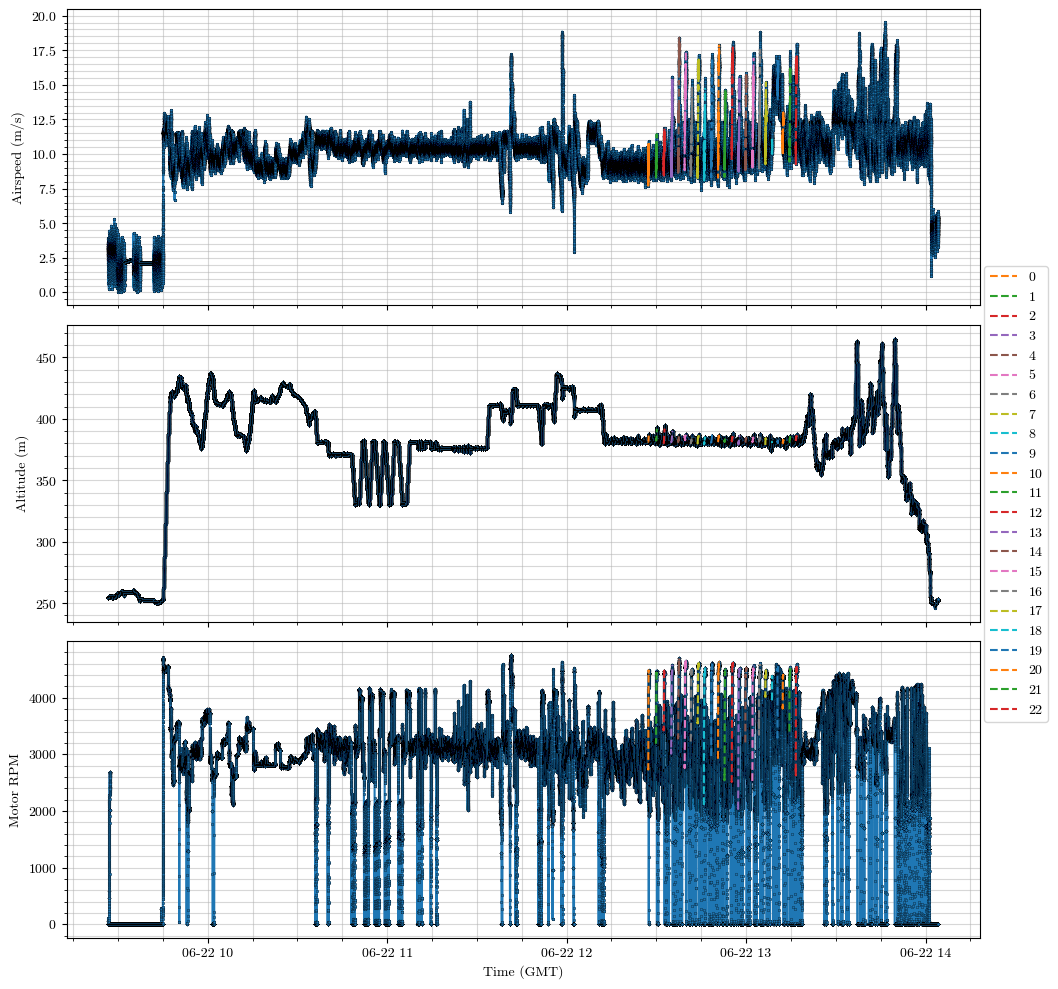

In [11]:
# Airspeed for Segments
[timeindex_v_h_RPM_fullsegmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

axs[0].plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    axs[0].plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + "")
axs[0].set_ylabel("Airspeed (m/s)")

# Altitude for Segments
axs[1].plot(df.index, df.Altitude_POS)
for i in np.arange(len(masks)):
    axs[1].plot(df.Altitude_POS[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[1].set_ylabel("Altitude (m)")
# axs[1].legend(loc='center left',
#           ncol=2, fancybox=True, bbox_to_anchor=(1.04, 0.5))

# RPM for Segments
axs[2].plot(df.index, df.MotorRPM)
for i in np.arange(len(masks)):
    axs[2].plot(df.MotorRPM[masks[i]], marker='', linestyle='--')#, label=str(i) + "")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (GMT)")

timeindex_v_h_RPM_fullsegmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_fullsegmented, f'{timeindex_v_h_RPM_fullsegmented=}'.split('=')[0], figure_path)

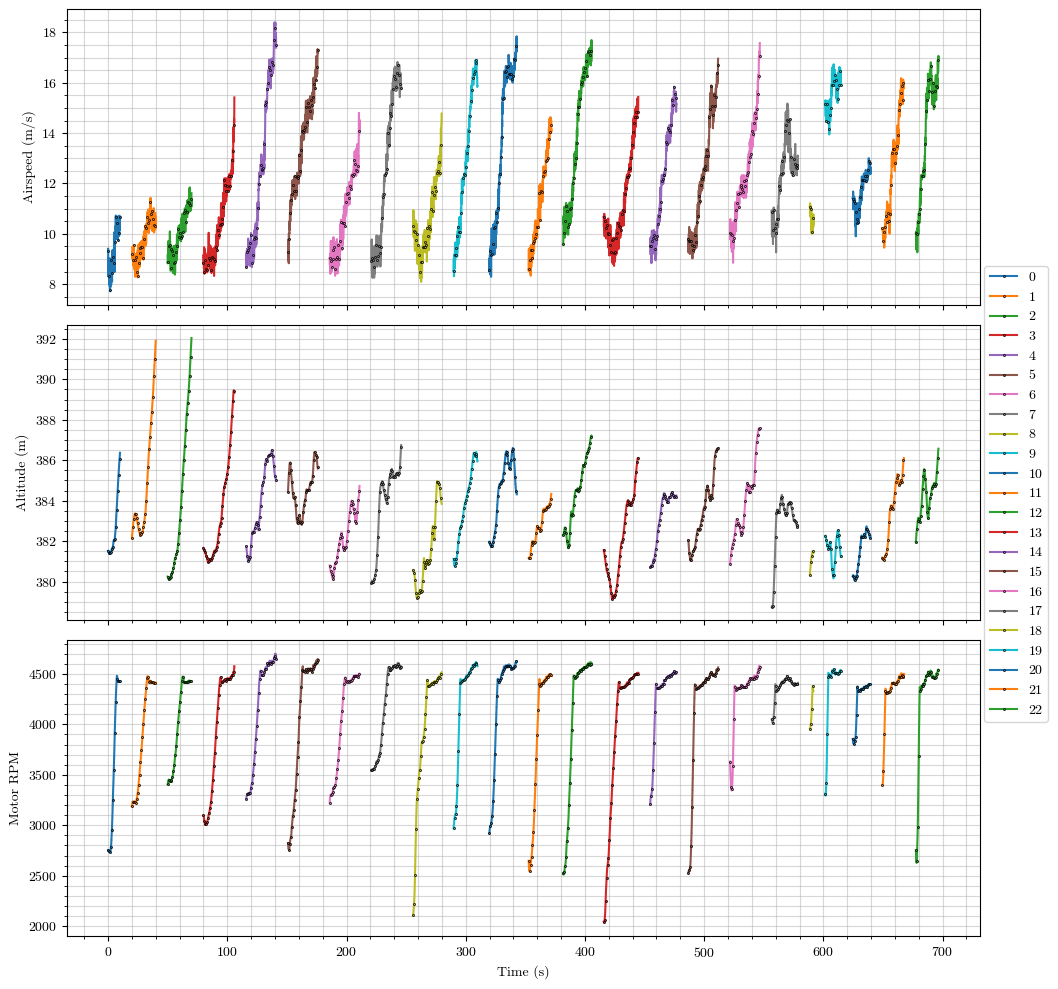

In [12]:
# Airspeed for Segments
[timeindex_v_h_RPM_segmented, axs] = plt.subplots(3,1, sharex=True, figsize=(10,10), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs[0].plot(time_s, df.Airspeed_Sensor0[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew,label=str(i) + "")
    # Altitude for Segments
    axs[1].plot(time_s, df.Altitude_POS[masks[i]], linestyle='-' , markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    # RPM for Segments
    axs[2].plot(time_s, df.MotorRPM[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)#, label=str(i) + "")
    t_init = time_s[-1]+10
axs[0].set_ylabel("Airspeed (m/s)")
axs[1].set_ylabel("Altitude (m)")
axs[2].set_ylabel("Motor RPM")
axs[2].set_xlabel("Time (s)")

timeindex_v_h_RPM_segmented.legend(loc=7, bbox_to_anchor=(1.06, 0.5))
#timeindex_v_segmented.tight_layout(rect=[0, 0, 1.2, 1.2])
plt.show()
main.save_figure(timeindex_v_h_RPM_segmented, f'{timeindex_v_h_RPM_segmented=}'.split('=')[0], figure_path)

### <a id='toc1_10_2_'></a>[Showing the Rotational Rate of Vehicle](#toc0_)

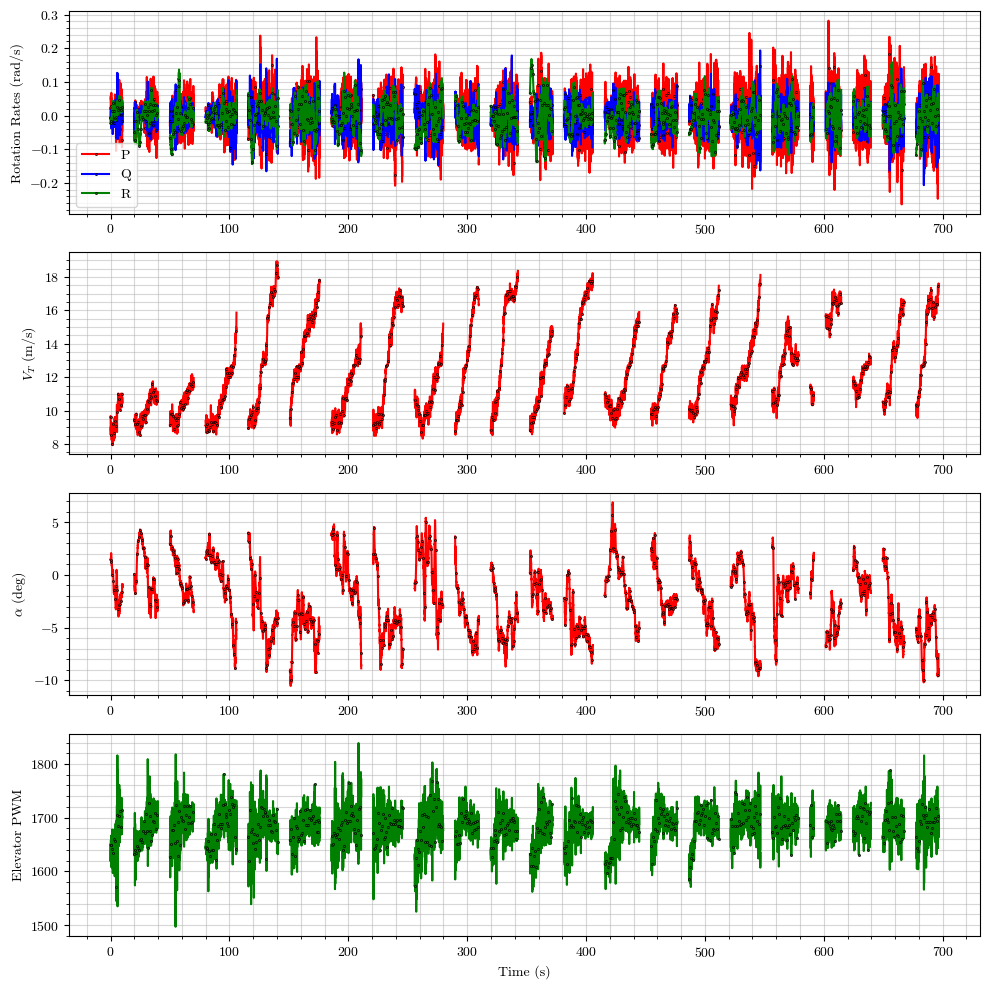

In [13]:
timeindex_PQR_V_alpha_PWM_segmented = plt.figure(figsize=(10,10))
plt.tight_layout()
t_init = 0
markerevery=80
markedgew=0.5

ax1 = plt.subplot(4,1,1)
ax2 = plt.subplot(4,1,2, sharex=ax1)
ax3 = plt.subplot(4,1,3, sharex=ax1)
ax4 = plt.subplot(4,1,4, sharex=ax1)
for i in range(len(masks)):
    dT = 0.01
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    ax1.plot(time_s, P[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='P')
    ax1.plot(time_s, Q[masks[i]], color='b', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='Q')
    ax1.plot(time_s, R[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, label='R')
    if i == 0:
        ax1.legend()
    ax1.set_ylabel("Rotation Rates (rad/s)")
    ax2.plot(time_s, v_tas[masks[i]], color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax2.set_ylabel("$V_T$ (m/s)")
    ax3.plot(time_s, np.rad2deg(alpha[masks[i]]), color='r', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax3.set_ylabel("$\\alpha$ (deg)")
    ax4.plot(time_s, df.ElevatorOut[masks[i]], color='g', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    ax4.set_ylabel("Elevator PWM")
    ax4.set_xlabel("Time (s)")
    t_init = time_s[-1]+10
plt.show()
main.save_figure(timeindex_PQR_V_alpha_PWM_segmented, f'{timeindex_PQR_V_alpha_PWM_segmented=}'.split('=')[0], figure_path)

### <a id='toc1_10_3_'></a>[Checking IMU Calibration Segment](#toc0_)

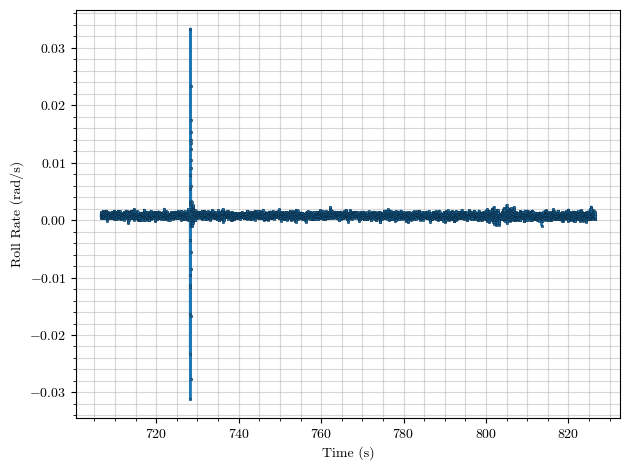

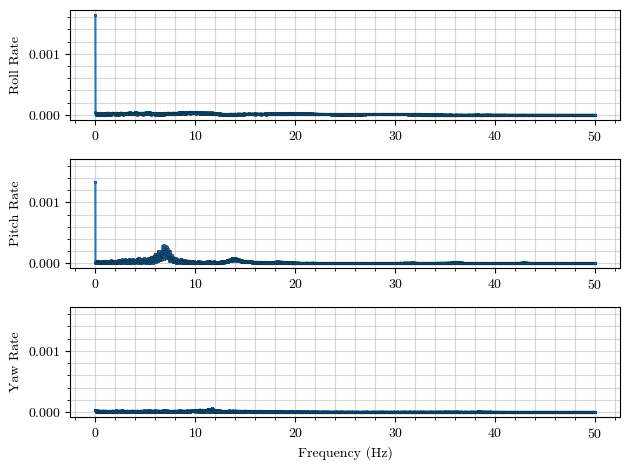

In [14]:
# Generating FFT of rotation rates

i = 0

segment_length = len(v_tas[acc_masks[i]])            # Integer segment length
time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)

plt.figure()
plt.plot(time_s, P[acc_masks[i]])
plt.xlabel("Time (s)")
plt.ylabel("Roll Rate (rad/s)")
plt.show()

# Getting Rates for Single Acceleration
p_fft = np.fft.fft(P[acc_masks[i]])
q_fft = np.fft.fft(Q[acc_masks[i]])
r_fft = np.fft.fft(R[acc_masks[i]])

xf = np.linspace(0.0, 1.0/(2.0*dT), segment_length//2)

plt.figure()

ax0 = plt.subplot(3,1,1)
ax1 = plt.subplot(3,1,2, sharey=ax0)
ax2 = plt.subplot(3,1,3, sharey=ax0)
ax0.plot(xf, 2.0/segment_length * np.abs(p_fft[:segment_length//2]))
ax1.plot(xf, 2.0/segment_length * np.abs(q_fft[:segment_length//2]))
ax2.plot(xf, 2.0/segment_length * np.abs(r_fft[:segment_length//2]))
ax0.set_ylabel("Roll Rate")
ax1.set_ylabel("Pitch Rate")
ax2.set_ylabel("Yaw Rate")
ax2.set_xlabel("Frequency (Hz)")
plt.show()

## <a id='toc1_11_'></a>[Post-Flight IMU Orientation Calibration](#toc0_)

Intended to fix any issues with the IMU being oriented differently from the aircrafts body frame axes.  The concept is to use a segment of data where the vehicle is stationary, and use that to confirm that the Euler Angles can be used to remove the effects of gravity from the IMU body acceleration measurements.  In addition, the magnitude of gravitational acceleration can be found from the stationary segment and used to remove gravitational acceleration as closely as possible.  

Items to be adjusted:
1. $\theta$ angle perturbed to make $\dot{U}$, $\dot{W}$ mean zero
2. $\phi$ angle perturbed to make $\dot{V}$ mean zero
3. $g$ taken as total sum of all raw IMU accelerations
4. Angle of attack, calculated using the adjusted pitch angle 

### <a id='toc1_11_1_'></a>[Calculating Body Accelerations w. Adjustment for g Magnitude](#toc0_)

In [15]:
thetap = 1.15 * (np.pi/180)  # Pitch perturbation from IMU orientation (Degrees)
phip = -1.3 * (np.pi/180)  # Roll perturbation from IMU orientation (Degrees)

IMUtotal = (np.sqrt(xp_acc**2 + yp_acc**2 + zp_acc**2))
g_IMU = np.mean(IMUtotal[acc_masks[0]])
print(g_IMU)

U_dot = xp_acc - g_IMU * np.sin(theta)
V_dot = yp_acc + g_IMU * np.cos(theta) * np.sin(phi)
W_dot = zp_acc + g_IMU * np.cos(theta) * np.cos(phi)

9.874354152246552


### <a id='toc1_11_2_'></a>[Calculating Body Accelerations w, Adjustment for IMU Orientation](#toc0_)

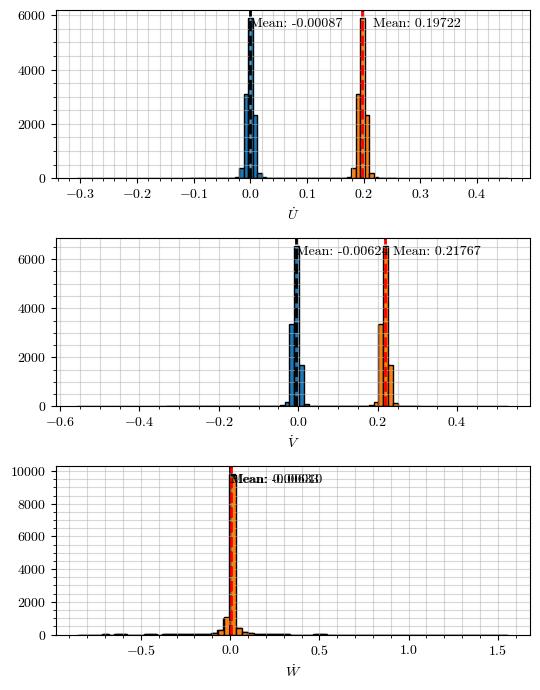

In [16]:
U_dotp = xp_acc - (g_IMU * np.sin(theta+thetap))
V_dotp = yp_acc + (g_IMU * np.cos(theta+thetap) * np.sin(phi+phip))
W_dotp = zp_acc + (g_IMU * np.cos(theta+thetap) * np.cos(phi+phip))

alpha_adjusted = (theta+thetap) - gamma

def plot_hist(masks):

    angle_offset_calibration = plt.figure(figsize=(5.5, 7))
    plt.title("Body Accelerations in X Direction")
    i = 0
    ax0 = plt.subplot(3,1,1)
    ax0.hist(U_dotp[masks[i]], bins=71, edgecolor='k', label='Adjusted')
    ax0.hist(U_dot[masks[i]], bins=71, edgecolor='k', label='Original')
    ax0.axvline(np.mean(U_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax0.axvline(np.mean(U_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax0.set_xlabel("$\dot{U}$")
    min_ylim, max_ylim = ax0.set_ylim()
    ax0.text(U_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dotp[masks[i]].mean()))
    ax0.text(U_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dot[masks[i]].mean()))

    ax1 = plt.subplot(3,1,2)
    ax1.hist(V_dotp[masks[i]], bins=71, edgecolor='k', label='Adjusted')
    ax1.hist(V_dot[masks[i]], bins=71, edgecolor='k', label='Original')
    ax1.axvline(np.mean(V_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax1.axvline(np.mean(V_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax1.set_xlabel("$\dot{V}$")
    min_ylim, max_ylim = ax1.set_ylim()
    ax1.text(V_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dotp[masks[i]].mean()))
    ax1.text(V_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dot[masks[i]].mean()))

    ax2 = plt.subplot(3,1,3)
    ax2.hist(W_dotp[masks[i]], bins=71, edgecolor='k', label='Adjusted')
    ax2.hist(W_dot[masks[i]], bins=71, edgecolor='k', label='Original')
    ax2.axvline(np.mean(W_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax2.axvline(np.mean(W_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax2.set_xlabel("$\dot{W}$")
    min_ylim, max_ylim = ax2.set_ylim()
    ax2.text(W_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dotp[masks[i]].mean()))
    ax2.text(W_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dot[masks[i]].mean()))

    plt.show()
    main.save_figure(angle_offset_calibration, f'{angle_offset_calibration=}'.split('=')[0], figure_path)

plot_hist(acc_masks)

## <a id='toc1_12_'></a>[Main Analysis for P_Req](#toc0_)

### <a id='toc1_12_1_'></a>[Power Required With IMU Orientation Adjustment](#toc0_)

In [17]:
# Beginning Power Required Calculation without IMU Orientation Adjustment

CT = prop.thrust_coeff(J)
T = CT * rho * n**2 * prop.diameter**4

P_req_t1 = (T * v_tas)
P_req_t2 = (mass * g * Vd_tas)
P_req_t3 = -(mass * U_dotp * v_tas)
P_req_t4 = -(mass * W_dotp * v_tas * alpha_adjusted)
P_req_t5 = mass * v_tas * (Q*U*alpha_adjusted - Q*W)
P_req_t6 = mass * v_tas * (R*V - P*V)

P_req_simple = P_req_t1 + P_req_t2 + P_req_t3
P_req_wdot = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4
P_req_rates = P_req_t1 + P_req_t2 + P_req_t3 + P_req_t4 + P_req_t5 + P_req_t6

D_simple = P_req_simple / v_tas
D_wdot = P_req_wdot / v_tas
D_rates = P_req_rates / v_tas

CD_simple = D_simple / (0.5 * rho * v_tas**2 * createv.area) # still need to estimate the wing area of createv
CD_wdot = D_wdot / (0.5 * rho * v_tas**2 * createv.area) # still need to estimate the wing area of createv
CD_rates = D_rates / (0.5 * rho * v_tas**2 * createv.area) # still need to estimate the wing area of createv

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_Cleaned_CREATeV_Performance_Analysis_MS4525/../../propellers.py:39: RuntimeWarning: invalid value encountered in subtract
  CT = (0.1298*J**3) - 0.2679*J**2 - 0.02553*J + 0.07525


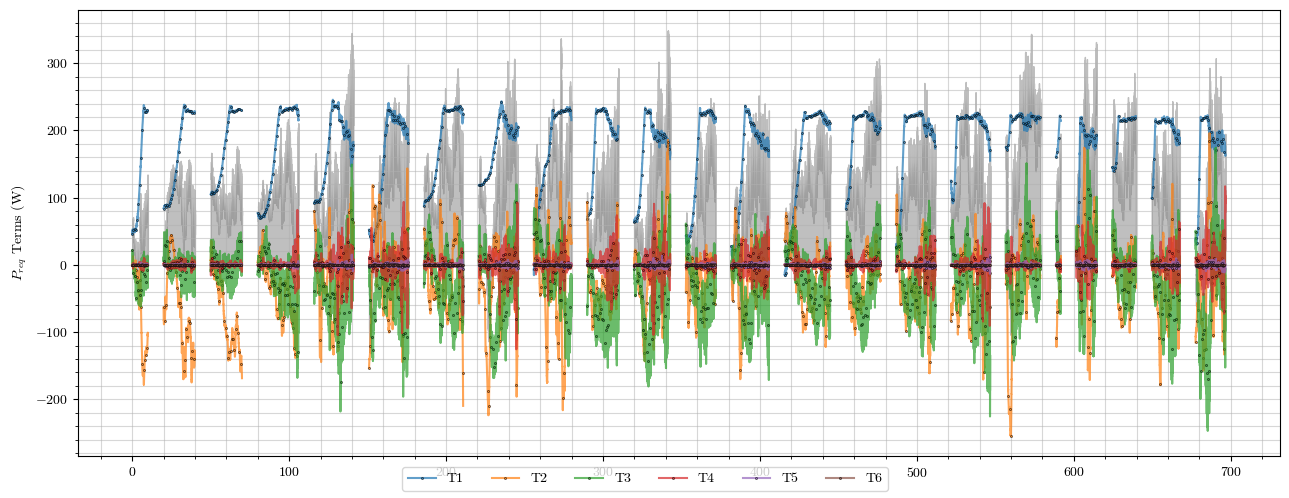

In [18]:
# Power Required Terms Comparison
[tiemindex_Preq_segmented, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, P_req_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, P_req_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, P_req_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, P_req_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.plot(time_s, P_req_t5[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#9467bd', alpha=0.7)
    axs.plot(time_s, P_req_t6[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#8c564b', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(P_req_wdot[masks[i]])), P_req_wdot[masks[i]], color='grey', alpha=0.5)
    t_init = time_s[-1]+10

tiemindex_Preq_segmented.legend(["T1", "T2", "T3", "T4", "T5", "T6"], loc='lower center', ncol=6)
axs.set_ylabel("$P_{req}$ Terms (W)")

plt.show()
main.save_figure(tiemindex_Preq_segmented, f'{tiemindex_Preq_segmented=}'.split('=')[0], figure_path)

#### <a id='toc1_12_1_1_'></a>[Notes for the investigation of Power Terms above](#toc0_)

By comparing the power required terms for those with IMU re-orientation, its clear that the IMU orientation has a tremendous effect on the U dot power term.  By doing the rotation, the overall acceleration in X is offset since it contains a component of gravitational acceleration.  

One way to verify that the acceleration in X is roughly correct would be to take the time derivative of airspeed, however airspeed is incredibly noisy.  Therefore, airspeed was low pass filtered to make the time derivative less noisy.  The end result was that the U dot couldn't be verified by the airspeed time derivative, since airspeed is so shaky.  This is precisely because of the small mass of the vehicle, and the airspeed data being so aweful.  

### <a id='toc1_12_2_'></a>[Lift Measurement with IMU Orientation Adjustment](#toc0_)

In [19]:
L_t1 = createv.weight * np.ones(np.shape(W_dotp))
L_t2 = -1*(createv.mass * W_dotp)
L_t3 = -1*(alpha*T)
L_t4 = alpha*createv.mass*U_dotp

L_simple = L_t1 + L_t2
L_full = L_t1 + L_t2 + L_t3 + L_t4

CL_simple = L_simple / (0.5 * rho * v_tas**2 * createv.area)
CL_full = L_full / (0.5 * rho * v_tas**2 * createv.area)
# CL = cl_finders.cl_usbanked(createv, q, phi, W_dot)

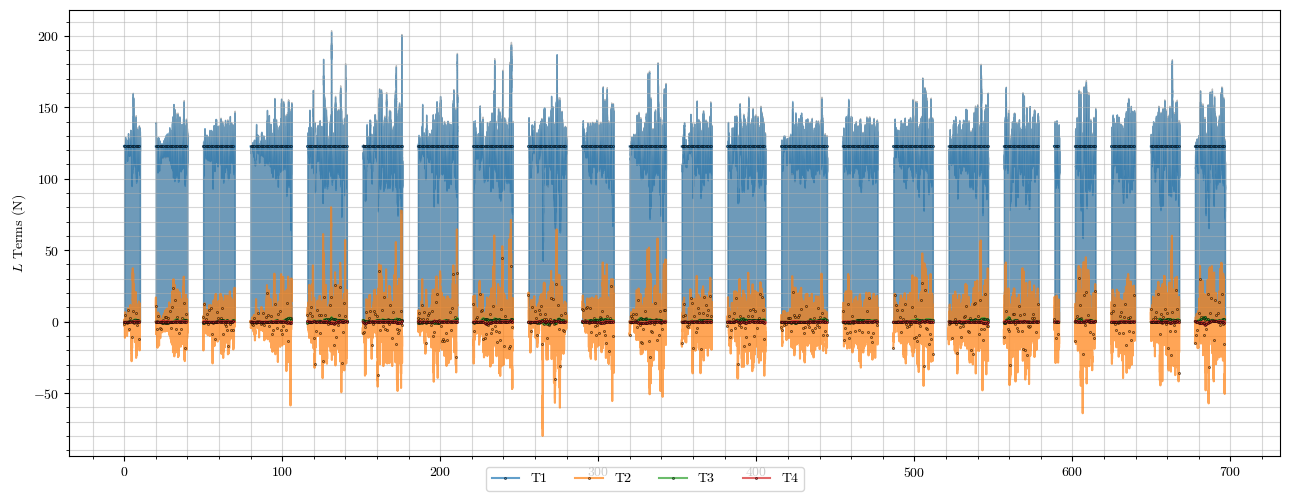

In [20]:
# Lift Term Comparison
[fig, axs] = plt.subplots(1,1, sharex=True, figsize=(13,5), dpi=100)
# timeindex_v_h_RPM_segmented.subplots_adjust(right=0.2, left=0.1)

markerevery=80
markedgew=0.5
t_init = 0
dT = 0.01
for i in range(len(masks)):
    segment_length = len(v_tas[masks[i]])            # Integer segment length
    time_s = np.linspace(t_init, (segment_length-1)*dT + t_init, segment_length)
    # Airspeed for Segments
    axs.plot(time_s, L_t1[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#1f77b4', alpha=0.7)
    axs.plot(time_s, L_t2[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#ff7f0e', alpha=0.7)
    axs.plot(time_s, L_t3[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#2ca02c', alpha=0.7)
    axs.plot(time_s, L_t4[masks[i]], linestyle='-', markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew, color='#d62728', alpha=0.7)
    axs.fill_between(time_s, np.zeros(np.shape(L_full[masks[i]])), L_full[masks[i]], color='grey', alpha=0.5)
    axs.fill_between(time_s, np.zeros(np.shape(L_simple[masks[i]])), L_simple[masks[i]], color='#1f77b4', alpha=0.5)
    t_init = time_s[-1]+10

fig.legend(["T1", "T2", "T3", "T4"], loc='lower center', ncol=6)
axs.set_ylabel("$L$ Terms (N)")

plt.show()
# main.save_figure(timeindex_v_h_RPM_segmented, f'{timeindex_v_h_RPM_segmented=}'.split('=')[0], figure_path)

#### <a id='toc1_12_2_1_'></a>[Lift Estimate Notes](#toc0_)

The IMU orientation doesn't affect the calculation of the lift coefficient substantially!
We can ignore these effects, and focus only on the gravity component and the W dot component to the lift.  

## <a id='toc1_13_'></a>[Collecting Total Results for Polar](#toc0_)

### <a id='toc1_13_1_'></a>[IMU Adjusted Results](#toc0_)

In [21]:
# Collecting Total CL, CD's
cl_total = cl_finders.total_segments_boolean(CL_simple, masks)
cd_total = cl_finders.total_segments_boolean(CD_wdot, masks)

In [22]:
# Collecting Total CL, CD for Good Runs
cl_total_goodruns = np.array([])
cd_total_goodruns = np.array([])
selection = np.arange(22)
bad_selection = [0, 5, 6, 7, 10, 16, 17, 22]

for i in selection:
    if i in bad_selection:
        continue
    cl_total_goodruns = np.append(cl_total_goodruns, CL_simple[masks[i]])
    cd_total_goodruns = np.append(cd_total_goodruns, CD_wdot[masks[i]])

## <a id='toc1_14_'></a>[Binning Total Results for Polar](#toc0_)

In [23]:
bins = np.linspace(0.05, 1.4, 50)
[cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_bin_means, cd_bin_stds, cd_bin_ci95s] = cl_finders.collect_bins(np.linspace(0.2, 1.1, 50), cl_total, cd_total)
[cl_bin_means_good, cl_bin_stds_good, cl_bin_ci95s_good, cd_bin_means_good, cd_bin_stds_good, cd_bin_ci95s_good] = cl_finders.collect_bins(np.linspace(0.2, 1.1, 50), cl_total_goodruns, cd_total_goodruns)

## <a id='toc1_15_'></a>[Plotting Results of Binning](#toc0_)

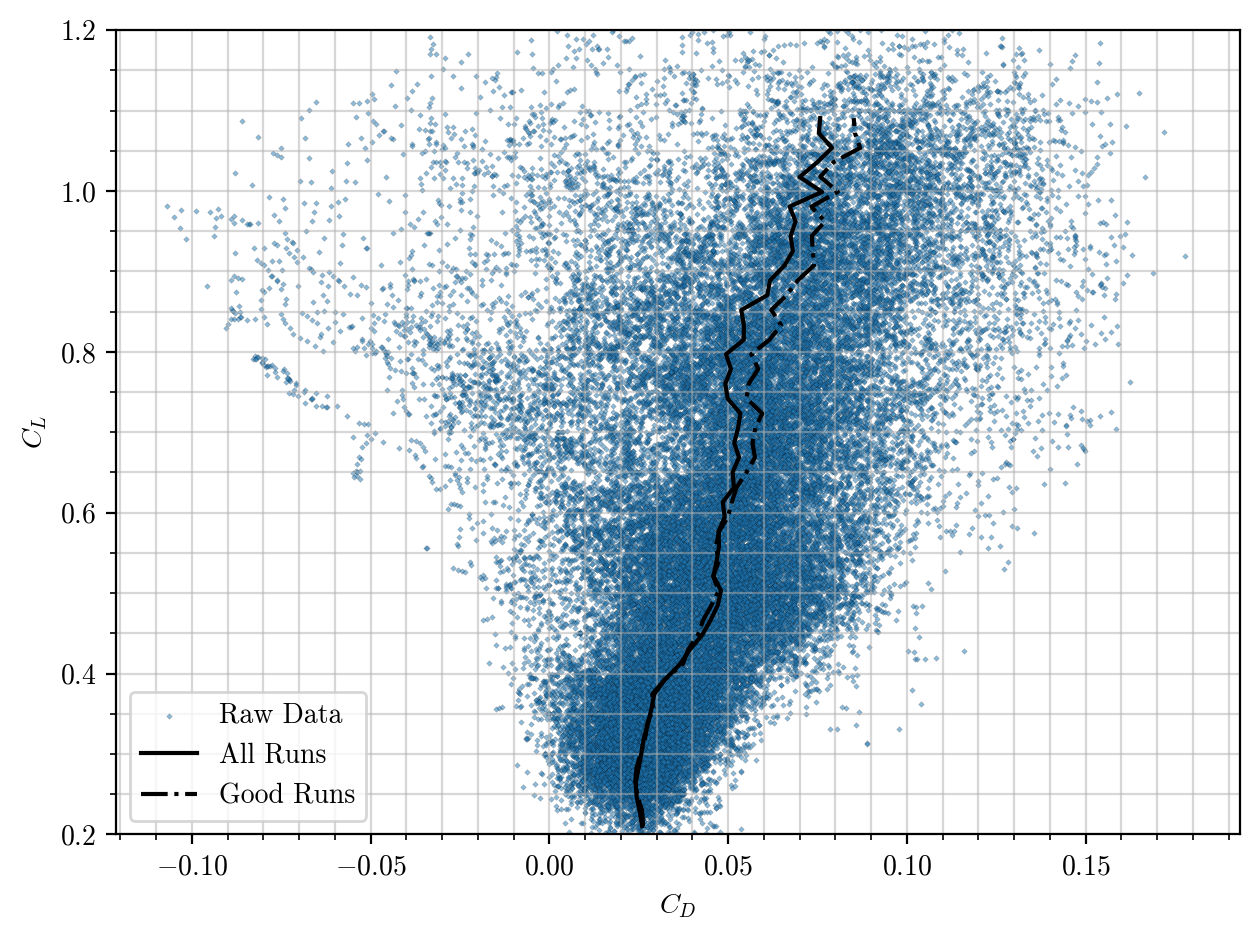

In [24]:
fig_dragpolar = plt.figure(dpi=200)
plt.scatter(cd_total, cl_total, marker='D', alpha=0.5, edgecolors=[0,0,0], s=2, linewidths=0.1, label='Raw Data')
plt.plot(cd_bin_means, cl_bin_means, marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', color='black', label='All Runs')
plt.plot(cd_bin_means_good, cl_bin_means_good, marker='', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-.', color='black', label='Good Runs')
plt.ylim([0.2, 1.2])
plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.show()
main.save_figure(fig_dragpolar, f'{fig_dragpolar=}'.split('=')[0], figure_path)

## <a id='toc1_16_'></a>[Performing Curve Fits to Find Polars](#toc0_)

In [25]:
polar_acceleration = cl_finders.cd2polar(createv, cd_total, cl_total, highorder=False)
polar_acceleration_good = cl_finders.cd2polar(createv, cd_total_goodruns, cl_total_goodruns, highorder=False)

print(polar_acceleration)
print(polar_acceleration_good)

0.11990161621267148
0.20693687274824646
[0.02915808 0.48671462]
[0.02780538 0.39062617]


## <a id='toc1_17_'></a>[Packaging the Results](#toc0_)

In [26]:
acceleration_binresult = cl_finders.packaging_binresults(cl_total, cl_bin_means, cl_bin_stds, cl_bin_ci95s, cd_total, cd_bin_means, cd_bin_stds, cd_bin_ci95s, polar_acceleration, createv)
acceleration_binresult_good = cl_finders.packaging_binresults(cl_total_goodruns, cl_bin_means_good, cl_bin_stds_good, cl_bin_ci95s_good, cd_total_goodruns, cd_bin_means_good, cd_bin_stds_good, cd_bin_ci95s_good, polar_acceleration_good, createv)

## <a id='toc1_18_'></a>[Saving Results to Disk](#toc0_)

In [27]:
# Exporting polar data
pd.to_pickle(acceleration_binresult, result_path+'acceleration_allresult.pkl')
pd.to_pickle(acceleration_binresult_good, result_path+'acceleration_goodresult.pkl')

## <a id='toc1_19_'></a>[Additional Plots](#toc0_)

In [28]:
polar_2022_ct = cl_finders.cd2polar(createv, ct_cruise_segresult_june13.ave_polar.CD, ct_cruise_segresult_june13.ave_polar.CL, highorder=False)

0.1814960984922529


In [29]:
# Fitting only to CL 1.1 and less

[CL_fitted_CT, CD_fitted_CT] = cl_finders.plotfittedpolar(createv, polar_2022_ct, [0.2, 1.1])
[CL_fitted_ACC, CD_fitted_ACC] = cl_finders.plotfittedpolar(createv, polar_acceleration, [0.2, 1.1])

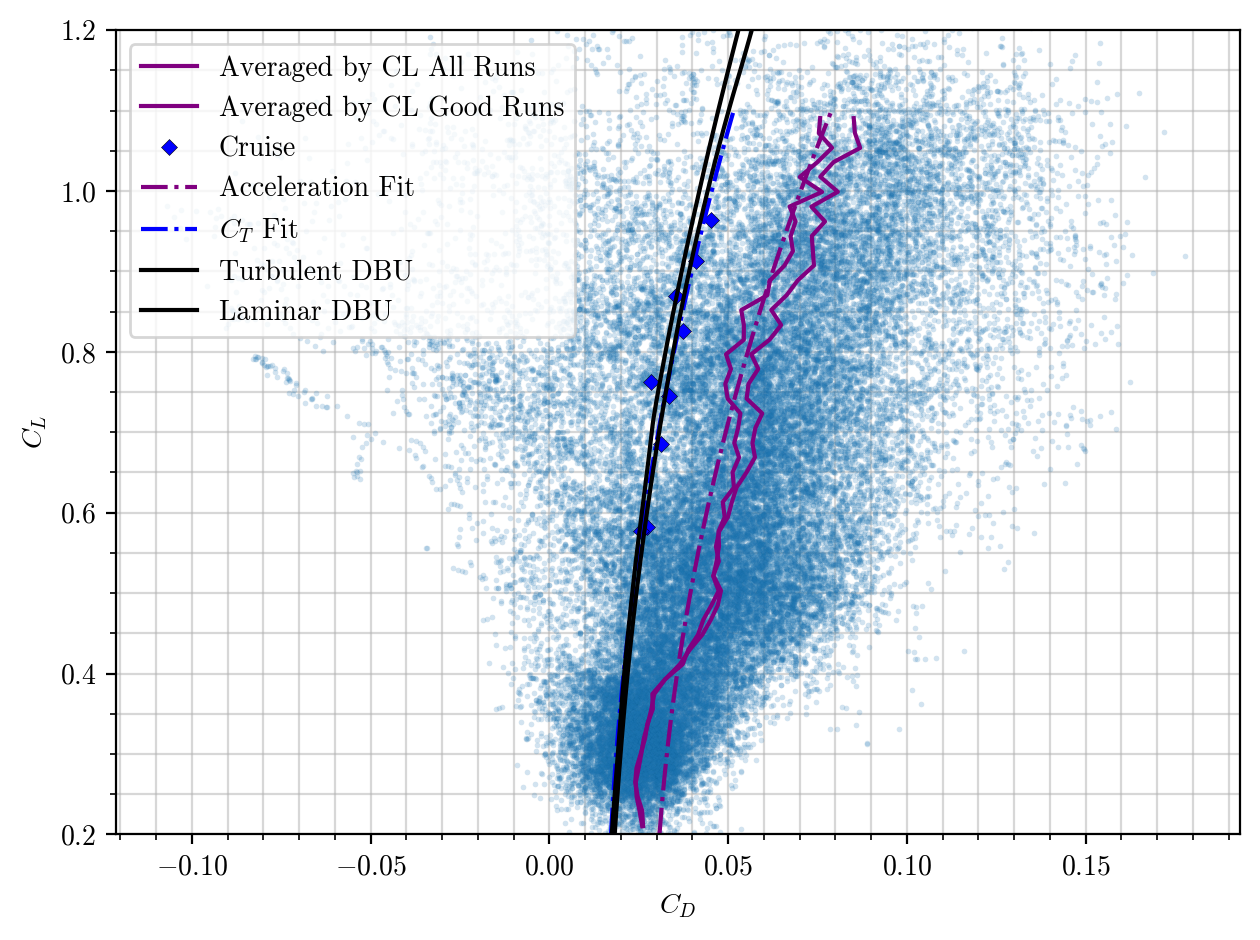

In [30]:
fig_dragpolar_context = plt.figure(dpi=200)

plt.plot(cd_total, cl_total, marker="o", markersize=2, markeredgewidth=0.01, markeredgecolor='black', linestyle='', alpha=0.2)
plt.plot(cd_bin_means, cl_bin_means, marker='', color='purple', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', label='Averaged by CL All Runs')
plt.plot(cd_bin_means_good, cl_bin_means_good, marker='', color='purple', markeredgecolor=[0,0,0], markersize=5, markeredgewidth=markedgew, linestyle='-', label='Averaged by CL Good Runs')


plt.plot(ct_cruise_segresult_june13.ave_polar.CD, ct_cruise_segresult_june13.ave_polar.CL, marker='D', color='blue', linestyle='', label="Cruise")

plt.plot(CD_fitted_ACC, CL_fitted_ACC, marker='', color='purple', linestyle='-.', label="Acceleration Fit")
plt.plot(CD_fitted_CT, CL_fitted_CT, marker='', color='blue', linestyle='-.', label="$C_T$ Fit")

plt.plot(build_turbulent.CD, build_turbulent.CL, marker='', color='black', linestyle='solid', label="Turbulent DBU")
plt.plot(build_laminar.CD, build_laminar.CL, marker='', color='black', linestyle='solid', label="Laminar DBU")

plt.legend()
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.ylim([0.2, 1.2])
plt.show()
main.save_figure(fig_dragpolar_context, f'{fig_dragpolar_context=}'.split('=')[0], figure_path)

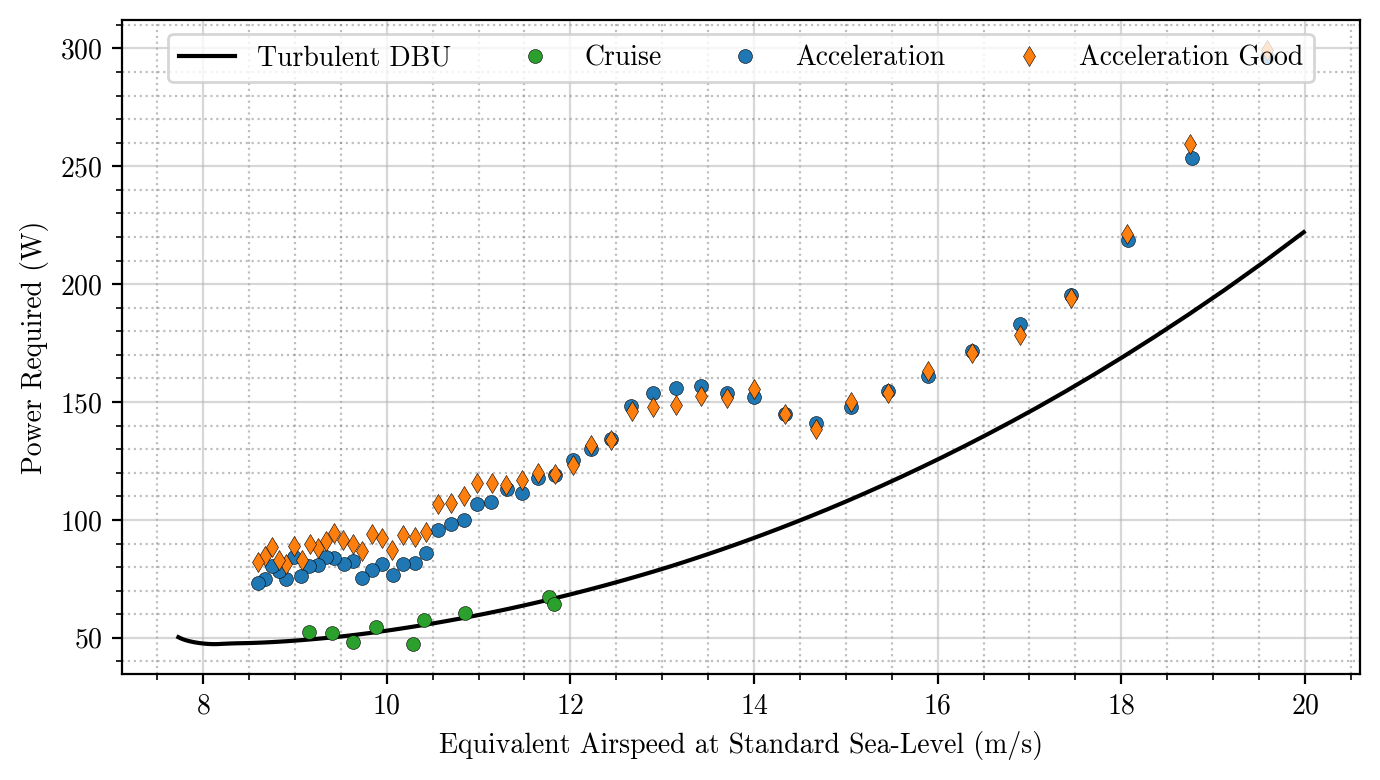

In [31]:
# Plot of Power Required Fits and Data #

[Pbin_acc, EAS_acc] = cl_finders.rawpolar2preqew(createv, cl_bin_means, cd_bin_means)
[Pbin_accgood, EAS_accgood] = cl_finders.rawpolar2preqew(createv, cl_bin_means_good, cd_bin_means_good)
[P_dbu, EAS_dbu] = cl_finders.rawpolar2preqew(createv, build_turbulent.CL, build_turbulent.CD)
[P_ct, EAS_ct] = cl_finders.rawpolar2preqew(createv, ct_cruise_segresult_june13.ave_polar.CL, ct_cruise_segresult_june13.ave_polar.CD)

fig_Preq_context = plt.figure(figsize=(7,4), dpi=200)
plt.errorbar(EAS_acc, Pbin_acc, label="Acceleration", linestyle='', marker='o', markersize=5)
plt.errorbar(EAS_accgood, Pbin_accgood , label="Acceleration Good", linestyle='', marker='d', markersize=5)
plt.plot(EAS_dbu, P_dbu, marker='', color='black', label='Turbulent DBU')
plt.plot(EAS_ct, P_ct, label='Cruise', linestyle='', marker='o', markersize=5)

plt.xlabel("Equivalent Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.legend(loc='upper center', ncol=4)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout()
plt.show()
main.save_figure(fig_Preq_context, f'{fig_Preq_context=}'.split('=')[0], figure_path, overwrite=True)